In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn as nn
import torch.nn.functional as F
from lora import count_parameters, apply_LoRA_tinyllama, save_AB_weights_tinyllama, load_AB_weights_tinyllama
# from transformers import BitsAndBytesConfig
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

model_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id)

c:\Users\huang\Desktop\M2IASD\NLP\env311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from data_utils import DataCollator, CustomDataCollator, CustomDataLoader, preprocess_fn, get_tokenizer
tokenizer = get_tokenizer()
dataset = load_dataset("tuetschek/e2e_nlg")
dataset = dataset.map(preprocess_fn, fn_kwargs={"tokenizer":tokenizer})
device = torch.device("cuda")
data_collator = DataCollator(pad_token_id=32000, max_length=256, device=device)
train_loader = iter(DataLoader(dataset=dataset["train"], batch_size=16, collate_fn=data_collator)) # type: ignore
batch = next(train_loader)
collate_fn = CustomDataCollator(pad_token_id=32000, max_length=256, device=device)
loader = CustomDataLoader(dataset["train"], batch_size=16, collate_fn=collate_fn) # type: ignore
batch_ = loader.next_batch()

Using the latest cached version of the module from C:\Users\huang\.cache\huggingface\modules\datasets_modules\datasets\tuetschek--e2e_nlg\bfeceb720929c2705bd227d1cfe5eaaab102a0bdac10dad618dac1e00c737430 (last modified on Sun Jun 16 15:39:04 2024) since it couldn't be found locally at tuetschek/e2e_nlg, or remotely on the Hugging Face Hub.


In [12]:
from time import time as t

train_loader = iter(DataLoader(dataset=dataset["train"], batch_size=16, collate_fn=data_collator))

In [10]:
t0 = t()
for i in range(2629):
    batch_ = loader.next_batch()
    if len(batch_['input_ids']) != 16:
        print(len(batch_['input_ids']))
print(t()-t0)

6.645299434661865


In [13]:
t0 = t()
for i in range(2629):
    batch = next(train_loader)
    if len(batch['input_ids']) != 16:
        print(len(batch['input_ids']))
print(t()-t0)

13
6.414844274520874


In [17]:
loader = CustomDataLoader(dataset["train"], batch_size=1, collate_fn=collate_fn) # type: ignore
batch = loader.next_batch()

In [19]:
lmask = batch['loss_mask']
tokenizer.decode(batch['input_ids'][lmask])

'Zizzi is a one star rated pub that is family friendly.</s>'

In [21]:
tokenizer.decode(batch['labels'])

'Zizzi is a one star rated pub that is family friendly.</s>'

In [2]:
LoRA_llama = apply_LoRA_tinyllama(target_layers=["q_proj","k_proj","v_proj","o_proj"], r=2, new_vocsize=32001)

Before Trainable parameters: 1,100,052,480
After Trainable parameters: 563,200


In [3]:
LoRA_llama.lm_head.weight.shape, LoRA_llama.model.embed_tokens.weight.shape

(torch.Size([32001, 2048]), torch.Size([32001, 2048]))

In [4]:
LoRA_llama.lm_head.weight.data[-1]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [9]:
LoRA_llama.model.layers[0].self_attn.q_proj.B.weight.data

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
load_AB_weights_tinyllama(
    save_dir=r"logs\2024-06-27\run1\model_weights", 
    model=LoRA_llama, 
    target_layers=["q_proj","k_proj","v_proj","o_proj"]
)

In [15]:
LoRA_llama.model.layers[0].self_attn.q_proj.base_layer

tensor([[-0.0015, -0.0024, -0.0068,  ...,  0.0053, -0.0010, -0.0134],
        [ 0.0026,  0.0059, -0.0177,  ...,  0.0006,  0.0005,  0.0106],
        [-0.0004,  0.0018, -0.0181,  ...,  0.0070,  0.0017, -0.0108],
        ...,
        [ 0.0151, -0.0018,  0.0112,  ..., -0.0061,  0.0195, -0.0146],
        [-0.0168, -0.0021, -0.0069,  ...,  0.0039, -0.0183,  0.0141],
        [-0.0165, -0.0016, -0.0076,  ...,  0.0041, -0.0182,  0.0143]])

In [18]:
from LoRA.data_utils import get_tokenizer
tokenizer = get_tokenizer()
LoRA_llama.resize_token_embeddings(len(tokenizer))

Embedding(32002, 2048)

In [19]:
device = torch.device("cuda")
LoRA_llama.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32002, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): LoRA_Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
            (B): Linear(in_features=2048, out_features=2, bias=False)
            (A): Linear(in_features=2, out_features=2048, bias=False)
          )
          (k_proj): LoRA_Linear(
            (base_layer): Linear(in_features=2048, out_features=256, bias=False)
            (B): Linear(in_features=2048, out_features=2, bias=False)
            (A): Linear(in_features=2, out_features=256, bias=False)
          )
          (v_proj): LoRA_Linear(
            (base_layer): Linear(in_features=2048, out_features=256, bias=False)
            (B): Linear(in_features=2048, out_features=2, bias=False)
            (A): Linear(in_features=2, out_features=256, bias=False)
          )
          (o_p

In [23]:
B,L = 4,256
vocsize = tokenizer.vocab_size
device = torch.device("cuda")
random_inputs = torch.randint(low=0, high=vocsize, size=(B,L)).to(device)

In [24]:
with torch.no_grad():
    outputs = LoRA_llama(random_inputs)

c:\Users\huang\Desktop\M2IASD\NLP\env311\Lib\site-packages\transformers\models\llama\modeling_llama.py:649: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [25]:
outputs.logits.shape

torch.Size([4, 256, 32002])

In [81]:
from datasets import load_dataset

dataset = load_dataset("tuetschek/e2e_nlg")

In [25]:
tokenizer.encode("Description:\n")

[1, 12953, 29901, 13]

In [26]:
tokenizer.decode([13])

'\n'

In [180]:
def preprocess_fn(sample, tokenizer):
    input_ids = tokenizer.encode(sample["meaning_representation"] + "\n Description:\n")
    labels = tokenizer.encode(sample["human_reference"] + "</s>", add_special_tokens=False)
    return dict(input_ids=input_ids, labels=labels)

In [181]:
dataset = dataset.map(preprocess_fn, fn_kwargs={"tokenizer":tokenizer})

Map: 100%|██████████| 4693/4693 [00:01<00:00, 3529.59 examples/s]


In [182]:
sample = dataset["train"][0]
sample.keys()

dict_keys(['meaning_representation', 'human_reference', 'input_ids', 'labels', 'length'])

In [183]:
len(sample["input_ids"])
print(tokenizer.decode(sample["input_ids"]))
print(len(sample["input_ids"]))
print(tokenizer.decode(sample["labels"]))

<s> name[The Vaults], eatType[pub], priceRange[more than £30], customer rating[5 out of 5], near[Café Adriatic]
 Description:

42
The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.</s>


In [184]:

class DataCollator:
    
    def __init__(self, pad_token_id, max_length, device):
        self.pad_token_id = pad_token_id
        self.max_length = max_length
        self.device = device

    def __call__(self, batch:list[dict]):
        '''
        The input of the model should be the restaurant description + <sep> + human_reference, as the model is pre-trained to predict the next token
        it'll do a next token prediction, if it were perfect, we'd have a shifted (by 1) input.
        We can then define the targets as the shifted input, and compute a loss. 
        The loss should only be computed for tokens after '<sep>'.
        '''
        batch_size = len(batch)
        input_ids = [sample['input_ids'] + sample['labels'] for sample in batch]
        attention_mask = torch.zeros(size=(batch_size, self.max_length,), dtype=torch.bool)
        loss_mask = torch.zeros(size=(batch_size, self.max_length,), dtype=torch.bool)
        for i, sample in enumerate(batch):
            attention_mask[i, :len(input_ids[i])] = 1
            loss_mask[i, len(sample['input_ids']):len(sample['input_ids'])+len(sample['labels'])] = True
            current_length = len(input_ids[i])
            input_ids[i] += [self.pad_token_id]*(self.max_length-current_length)
        input_ids = torch.tensor(input_ids, dtype=torch.int16)
        labels = torch.cat([torch.tensor(sample["labels"], dtype=torch.int64) for sample in batch])
        return dict(input_ids=input_ids, attention_mask=attention_mask, loss_mask=loss_mask, labels=labels)

In [185]:
from torch.utils.data import DataLoader

collate_fn = DataCollator(32000, 128, None)
loader = DataLoader(dataset["train"], batch_size=4, collate_fn=collate_fn)

In [186]:
batch = next(iter(loader))
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'loss_mask', 'labels'])

In [187]:
batch["input_ids"].shape

torch.Size([4, 128])

In [188]:
batch["input_ids"][0]

tensor([    1,  1024, 29961,  1576,   478,  1292, 29879,  1402, 17545,  1542,
        29961,  5467,  1402,  8666,  6069, 29961,  5514,  1135, 15151, 29941,
        29900,  1402, 11962, 21700, 29961, 29945,   714,   310, 29871, 29945,
         1402,  2978, 29961, 29907, 28059, 27449,  2454, 29962,    13, 12953,
        29901,    13,   450,   478,  1292, 29879,  2529,  2978,   315, 28059,
        27449,  2454,   756,   263, 29871, 29945,  5810, 21700, 29889, 29871,
         1588,  1575,  1369,   472, 15151, 29941, 29900, 29889,     2, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000],

In [199]:
assert batch["input_ids"][batch["loss_mask"]].shape == batch["labels"].shape

In [200]:
print("batch['input_ids'][losk_mask] :", tokenizer.decode(batch["input_ids"][batch['loss_mask']]))
print("actual label :", tokenizer.decode(batch["labels"]))

batch['input_ids'][losk_mask] : The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.</s> Close to Café Brazil, The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £10.50. Delicious Pub food.</s> The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.</s> Located near The Sorrento is a French Theme eatery and coffee shop called The Mill, with a price range at £20-£25 it is in the riverside area.</s>
actual label : The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.</s> Close to Café Brazil, The Cambridge Blue pub serves delicious Tuscan Beef for the cheap price of £10.50. Delicious Pub food.</s> The Eagle is a low rated coffee shop near Burger King and the riverside that is family friendly and is less than £20 for Japanese food.</s> Located near The Sorrento is a French Theme eatery and coffee shop called The Mill, with a price range at 

In [114]:
batch["labels"].shape

torch.Size([139])

In [8]:
from data_utils import get_tokenizer

tokenizer = get_tokenizer()

In [10]:
out = tokenizer(
    dataset["train"][25615]['meaning_representation']+'.\nDescription:\n'+dataset["train"][0]['human_reference'],
    max_length=256,
    truncation=True,
    padding='max_length',
)

out

{'input_ids': [1, 1024, 29961, 1576, 21139, 10335, 15472, 1402, 17545, 1542, 29961, 29878, 22837, 424, 1402, 9687, 29961, 10512, 713, 1402, 8666, 6069, 29961, 5514, 1135, 15151, 29941, 29900, 1822, 13, 9868, 29901, 13, 1576, 478, 1292, 29879, 2529, 2978, 315, 28059, 27449, 2454, 756, 263, 29871, 29945, 5810, 21700, 29889, 29871, 1588, 1575, 1369, 472, 15151, 29941, 29900, 29889, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32

In [11]:
out2 = tokenizer(
    dataset["train"][25615]['meaning_representation']+'.\nDescription:\n'+dataset["train"][0]['human_reference'],
    max_length=256,
    truncation=True,
    padding='max_length',
)

out2

{'input_ids': [1, 1024, 29961, 1576, 21139, 10335, 15472, 1402, 17545, 1542, 29961, 29878, 22837, 424, 1402, 9687, 29961, 10512, 713, 1402, 8666, 6069, 29961, 5514, 1135, 15151, 29941, 29900, 1822, 13, 9868, 29901, 13, 1576, 478, 1292, 29879, 2529, 2978, 315, 28059, 27449, 2454, 756, 263, 29871, 29945, 5810, 21700, 29889, 29871, 1588, 1575, 1369, 472, 15151, 29941, 29900, 29889, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32

In [64]:
print(out)

<s> name[The Vaults], eatType[pub], priceRange[more than £30], customer rating[5 out of 5], near[Café Adriatic].
Description:
The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.


In [56]:
tokenizer.encode(
    dataset["train"][0]['meaning_representation']+'.\nDescription:\n'+dataset["train"][0]['human_reference'])

[1,
 1024,
 29961,
 1576,
 478,
 1292,
 29879,
 1402,
 17545,
 1542,
 29961,
 5467,
 1402,
 8666,
 6069,
 29961,
 5514,
 1135,
 15151,
 29941,
 29900,
 1402,
 11962,
 21700,
 29961,
 29945,
 714,
 310,
 29871,
 29945,
 1402,
 2978,
 29961,
 29907,
 28059,
 27449,
 2454,
 1822,
 13,
 9868,
 29901,
 13,
 1576,
 478,
 1292,
 29879,
 2529,
 2978,
 315,
 28059,
 27449,
 2454,
 756,
 263,
 29871,
 29945,
 5810,
 21700,
 29889,
 29871,
 1588,
 1575,
 1369,
 472,
 15151,
 29941,
 29900,
 29889]

In [57]:
tokenizer.decode([29900, 29889])

'0.'

In [11]:
# def process_data(sample):
#     return tokenizer(sample["text"])

data = load_dataset("tatsu-lab/alpaca")
data = data.map(process_data, batched=True)

In [30]:
from LoRA.data_utils import DataCollator

collate_fn = DataCollator(tokenizer, 256, device)
train[0]

{'meaning_representation': 'name[The Vaults], eatType[pub], priceRange[more than £30], customer rating[5 out of 5], near[Café Adriatic]',
 'human_reference': 'The Vaults pub near Café Adriatic has a 5 star rating.  Prices start at £30.'}

In [90]:
sample = tokenizer(train[0]["meaning_representation"]+"<sep>", max_length=256, truncation=True, padding="max_length")
sample["input_ids"] = torch.tensor(sample["input_ids"]).view(-1,1).to(device)
sample["attention_mask"] = torch.tensor(sample["attention_mask"]).view(-1,1).to(device)

In [91]:
sample

{'input_ids': tensor([[    1],
        [ 1024],
        [29961],
        [ 1576],
        [  478],
        [ 1292],
        [29879],
        [ 1402],
        [17545],
        [ 1542],
        [29961],
        [ 5467],
        [ 1402],
        [ 8666],
        [ 6069],
        [29961],
        [ 5514],
        [ 1135],
        [15151],
        [29941],
        [29900],
        [ 1402],
        [11962],
        [21700],
        [29961],
        [29945],
        [  714],
        [  310],
        [29871],
        [29945],
        [ 1402],
        [ 2978],
        [29961],
        [29907],
        [28059],
        [27449],
        [ 2454],
        [29962],
        [32001],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],
        [32000],


In [55]:
sample = tokenizer(train[0]["meaning_representation"])
# sample["input_ids"].append(tokenizer.sep_token_id)
# sample["input_ids"] = torch.tensor(sample["input_ids"])
# sample["attention_mask"] = torch.tensor(sample["attention_mask"])
sample.append(tokenizer.sep_token_id)
sample = torch.tensor(sample).to(device)
# sample.to(device)

In [56]:
sample

tensor([    1,  1024, 29961,  1576,   478,  1292, 29879,  1402, 17545,  1542,
        29961,  5467,  1402,  8666,  6069, 29961,  5514,  1135, 15151, 29941,
        29900,  1402, 11962, 21700, 29961, 29945,   714,   310, 29871, 29945,
         1402,  2978, 29961, 29907, 28059, 27449,  2454, 29962, 32001],
       device='cuda:0')

In [96]:
with torch.no_grad():
    out = LoRA_llama.generate(**sample)

KeyboardInterrupt: 

In [97]:
out.logits.shape

torch.Size([256, 1, 32002])

In [95]:
tokenizer.decode(out.logits[-1,0,:].argmax())

'ment'

In [125]:
import random

def see_prediction(sample):
    text = sample["meaning_representation"] + "<sep>"
    text = tokenizer(text, return_tensors="pt").to(device)
    outputs = LoRA_llama.generate(**text, max_new_tokens=20)
    print("Description:", sample["meaning_representation"])
    print("model output:", tokenizer.decode(outputs[0]))
    print("human reference:", sample["human_reference"])

    
sample_id = random.randint(0,100)
sample = train[sample_id]
see_prediction(sample)

Description: name[The Rice Boat], food[Italian], customer rating[low], area[riverside], familyFriendly[yes]
model output: <s> name[The Rice Boat], food[Italian], customer rating[low], area[riverside], familyFriendly[yes]<sep> The Waterman is a family friendly restaurant in the riverside. It is located near The Rice
human reference: North of the city centre, overlooking the river, is a family restaurant named The Rice Boat. It serves Italian food and is rated 1 star.


In [123]:
outputs.shape

torch.Size([1, 39])

In [13]:
import numpy as np
split = "train"
input_lengths = np.array(
    [len(dataset[split][i]["human_reference"])+ len(dataset[split][i]["meaning_representation"])
    for i in range(len(dataset[split]))]
)
print("Longest input_text (MR+HR):", np.max(input_lengths))

Longest input_text (MR+HR): 442


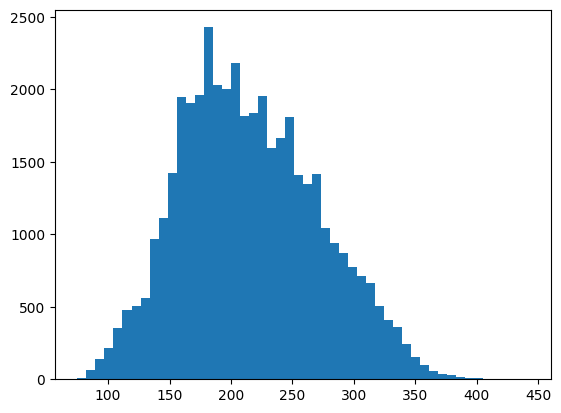

In [14]:
import matplotlib.pyplot as plt

plt.hist(input_lengths, bins=50);

In [15]:
dataset["test"][0]

{'meaning_representation': 'name[Blue Spice], eatType[coffee shop], area[city centre]',
 'human_reference': 'A coffee shop in the city centre area called Blue Spice.'}

In [16]:
print(tokenizer.special_tokens_map)
tokenizer.add_special_tokens({"pad_token":"[PAD]"})
tokenizer.convert_tokens_to_ids('[PAD]')
tokenizer.add_special_tokens({"sep_token":"<sep>"})
tokenizer.convert_tokens_to_ids('<sep>')
print(tokenizer.special_tokens_map)
print(tokenizer.all_special_ids)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}
{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '<sep>', 'pad_token': '[PAD]'}
[1, 2, 0, 32001, 32000]


In [17]:
LoRA_llama.resize_token_embeddings(len(tokenizer))

Embedding(32002, 2048)

In [18]:
assert LoRA_llama.lm_head.weight.shape == LoRA_llama.model.embed_tokens.weight.shape == (32002, 2048)

In [19]:
# def preprocess_fn(sample, tokenizer):
#     input_text = sample["meaning_representation"] + "<sep>" + sample["human_reference"]
#     preprocessed_sample = tokenizer(
#         input_text,
#         max_length=384, #maybe try 384
#         truncation=True,
#         padding="max_length",
#     )
#     preprocessed_sample["labels"] = tokenizer.encode(sample["human_reference"])
#     preprocessed_sample["cutoff"] = len(sample["meaning_representation"])
#     return preprocessed_sample

# preprocessed_train = dataset["train"].map(preprocess_fn, fn_kwargs={"tokenizer":tokenizer})

In [20]:
from LoRA.data_utils import DataCollator

In [21]:
device = torch.device("cuda")
data_collator = DataCollator(tokenizer=tokenizer, max_length=384, device=device)

In [22]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset["train"], batch_size=16, collate_fn=data_collator)

In [23]:
batch = next(iter(train_loader))

In [24]:
pred = batch["input_ids"][batch["loss_mask"]]
targets = batch["labels"][batch["loss_mask"]]

In [25]:
pred = torch.randn(size=(461, 32001), dtype=torch.float32)

In [26]:
print(pred.shape, targets.shape)
print(pred.dtype, targets.dtype)

torch.Size([461, 32001]) torch.Size([461])
torch.float32 torch.int64


In [27]:
loss_fn = nn.CrossEntropyLoss()
loss_fn(pred, targets.cpu())

tensor(10.8535)

In [28]:
emb_proj = LoRA_llama.model.embed_tokens(batch["input_ids"])
emb_proj.shape

torch.Size([16, 384, 2048])

In [31]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'loss_mask'])

In [42]:
text = "### Instruction:\nDescribe the structure of an atom.\n\n### Response:\n"
inputs = tokenizer(text, return_tensors="pt").to(device)
inputs.keys()

dict_keys(['input_ids', 'attention_mask'])

In [43]:
LoRA_llama(**inputs)

CausalLMOutputWithPast(loss=None, logits=tensor([[[ -1.7340,   1.9886,   2.8448,  ...,  -3.0332,   0.0760,   2.2170],
         [ -9.9306,  -9.8902,   6.2598,  ...,  -1.3404,   2.7176,  -0.4299],
         [ -7.4265,  -7.5441,   2.2056,  ...,  -2.5291,   0.0341,  -0.1919],
         ...,
         [-11.4517, -11.7094,   2.0852,  ...,  -3.5456,   1.8316,   1.0591],
         [-10.8050, -10.9598,   5.8787,  ...,  -2.9804,   2.1922,  -0.5307],
         [ -8.6776,  -8.8169,   8.2351,  ...,   2.4877,  -1.0934,  -2.7130]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[ 2.1541e-02, -3.6334e-02,  1.6648e-02,  ..., -1.9140e-02,
           -4.5862e-04, -1.4910e-02],
          [ 9.5936e-02, -9.9026e-02,  1.5491e-01,  ...,  9.9799e-02,
            1.1202e-01,  1.0081e-01],
          [ 2.7698e-01,  3.1118e-02,  6.6651e-02,  ..., -2.4216e-02,
            3.6755e-02, -1.2002e-02],
          ...,
          [-2.5687e-01,  1.0254e-01, -3.8412e-02,  ...,  5.2203e-02,
  

In [50]:
batch["attention_mask"][0]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
with torch.no_grad():
    outputs = LoRA_llama(**dict(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]))

In [55]:
outputs.logits.shape

torch.Size([16, 384, 32002])